<a href="https://colab.research.google.com/github/tanishq252/AI-ML-DS-Learning-Series/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download chetankv/dogs-cats-images


mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 433M/435M [00:02<00:00, 175MB/s]
100% 435M/435M [00:02<00:00, 183MB/s]


In [ ]:
! unzip dogs-cats-images.zip

#Importing Dataset and libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, SeparableConv2D, Input, BatchNormalization

#Data Preprocessing(train+test)
##Using Image Data Generator to get random data to work upon

In [8]:
# train data geneerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

train_set = train_datagen.flow_from_directory(
    'dc/dataset/training_set',
    target_size = (64,64),
    batch_size = 32,
    class_mode = 'binary'
)

Found 8000 images belonging to 2 classes.


In [9]:
# test data geneerator
test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

test_set = test_datagen.flow_from_directory(
    'dc/dataset/test_set',
    target_size = (64,64),
    batch_size = 32,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.


#Visualising the data from dataset to get an idea whether it consists proper data or not

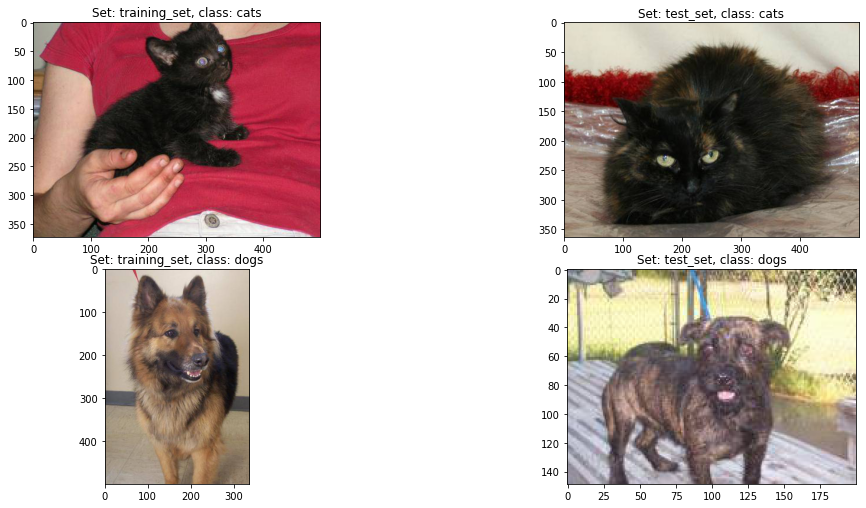

In [10]:
import os
input_path = '/content/dc/dataset/'

fig, ax = plt.subplots(2, 2, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['training_set', 'test_set']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/cats/'+os.listdir(set_path+'/cats')[0]), cmap='gray')
    ax[i].set_title('Set: {}, class: cats'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/dogs/'+os.listdir(set_path+'/dogs')[0]), cmap='gray')
    ax[i+2].set_title('Set: {}, class: dogs'.format(_set))

#Building CNN Model

In [29]:
inputs = Input(shape=(64, 64, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPool2D(pool_size=(2, 2), strides = 2)(x)

# Second conv block
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2), strides = 2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=64, activation='relu')(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

#Training the CNN

In [30]:
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
hist = model.fit_generator(
           train_set, steps_per_epoch=train_set.samples // 32, 
           epochs=15, validation_data=test_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/15
250/250 [==============================] - 38s 152ms/step - loss: 0.5548 - accuracy: 0.7181 - val_loss: 0.5656 - val_accuracy: 0.7105
Epoch 2/15
250/250 [==============================] - 43s 171ms/step - loss: 0.5260 - accuracy: 0.7377 - val_loss: 0.5193 - val_accuracy: 0.7430
Epoch 3/15
250/250 [==============================] - 38s 151ms/step - loss: 0.4971 - accuracy: 0.7624 - val_loss: 0.4900 - val_accuracy: 0.7640
Epoch 4/15
250/250 [==============================] - 38s 151ms/step - loss: 0.4875 - accuracy: 0.7625 - val_loss: 0.6861 - val_accuracy: 0.6555
Epoch 5/15
250/250 [==============================] - 38s 151ms/step - loss: 0.4698 - accuracy: 0.7721 - val_loss: 0.5198 - val_accuracy: 0.7480
Epoch 6/15
250/250 [==============================] - 38s 152ms/step - loss: 0.4499 - accuracy: 0.7899 - val_loss: 0.4781 - val_accuracy: 0.7775
Epoch 7/15
250/250 [==============================] - 38s 152ms/step - loss: 0.4461 - accuracy: 0.7864 - val_loss: 0.4623 - val_ac

# Visualising the structure of the model

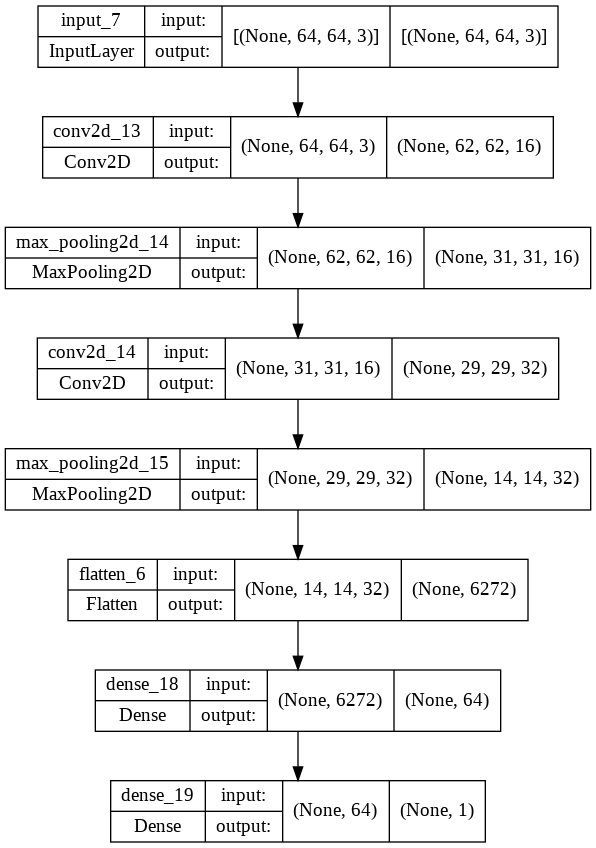

In [73]:
from tensorflow.keras.utils import plot_model

plot_model(model = model, show_shapes=True)

# Appending the data from test data set and also take the predicted values using the model for calculation of confusion matrix

In [77]:
import cv2
from keras.preprocessing import image

test_data = []
test_labels = []
test_labels_non_cat = []
predictions = []

for cond in ['/cats/', '/dogs/']:
        for img in (os.listdir('dc/dataset/test_set/'+ cond)):
            img = plt.imread('dc/dataset/test_set/'+cond+img)
            img = cv2.resize(img, (64, 64))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/cats/':
                test_labels.append(0)
                test_labels_non_cat.append(0)
            elif cond=='/dogs/':
                test_labels.append(1)
                test_labels_non_cat.append(1)
            test_data.append(img)

for cond in ['/cats/', '/dogs/']:
        for img in (os.listdir('dc/dataset/test_set/'+ cond)):
            test_im = plt.imread('dc/dataset/test_set/'+cond+img)
            test_im = cv2.resize(test_im, (64, 64))
            test_im = image.img_to_array(test_im)
            test_im = np.expand_dims(test_im, axis = 0)
            res = model.predict(test_im)
            predictions.append(res[0][0])



In [79]:
pred = []
for i in predictions:
  if i>0.5:
    pred.append(1)
  else:
    pred.append(0)

In [49]:
test_data = np.array(test_data)


In [50]:
print(test_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
test_data

# Accuracy and loss comparison for training and validation data

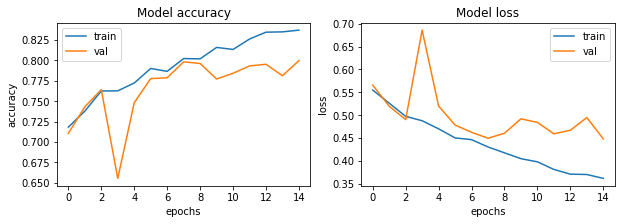

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# A function to take image as input and return predicted output

In [69]:
from keras.preprocessing import image

def predictOutput(img):
  test_im = image.load_img(img, target_size = (64,64))
  test_im = image.img_to_array(test_im)
  test_im = np.expand_dims(test_im, axis = 0)
  res = model.predict(test_im)
  if(res[0][0] == 0):
    return 'cat'
  else:
    return 'dog'

In [81]:
print(pred)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 

# Confusion Matrix


TEST METRICS ----------------------
Accuracy: 67.25%
Precision: 61.09324758842444%
Recall: 95.0%
F1-score: 74.36399217221135

TRAIN METRIC ----------------------
Train acc: 83.67
CONFUSION MATRIX ------------------
[[395 605]
 [ 50 950]]


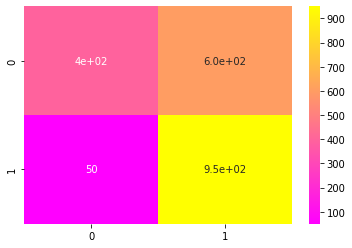

In [82]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns



acc = accuracy_score(test_labels, pred)*100
cm = confusion_matrix(test_labels, pred)
tn, fp, fn, tp = cm.ravel()



print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

print('CONFUSION MATRIX ------------------')
print(cm)
sns.heatmap(cm,cmap='spring',annot=True)

# Taking input from folder and visualising data along with prediction

Text(0.5, 1.0, 'predicted output : cat')

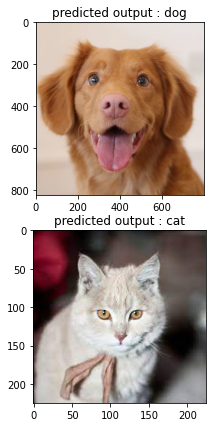

In [72]:
fig, ax = plt.subplots(2,1, figsize=(15, 7))
ax = ax.ravel()
ax[0].imshow(plt.imread('doggie.jpg'), cmap='gray')
ax[0].set_title("predicted output : "+predictOutput('doggie.jpg'))
ax[1].imshow(plt.imread('kittie.jpg'), cmap='gray')
ax[1].set_title("predicted output : "+predictOutput('kittie.jpg'))